In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

In [2]:
df = pd.read_csv("timeforecast/daily-minimum-temperatures-in-me.csv", parse_dates=["Date"])

In [3]:
df.head()

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 57.2+ KB


In [5]:
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].str.replace(r"[^0-9.]", "", regex = True)

In [6]:
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')

In [7]:
df.tail()

,Date,Daily minimum temperatures
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [8]:
df['Daily minimum temperatures'].describe().round(2)

count    3650.00
mean       11.18
std         4.07
min         0.00
25%         8.30
50%        11.00
75%        14.00
max        26.30
Name: Daily minimum temperatures, dtype: float64

In [9]:
df.head()

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


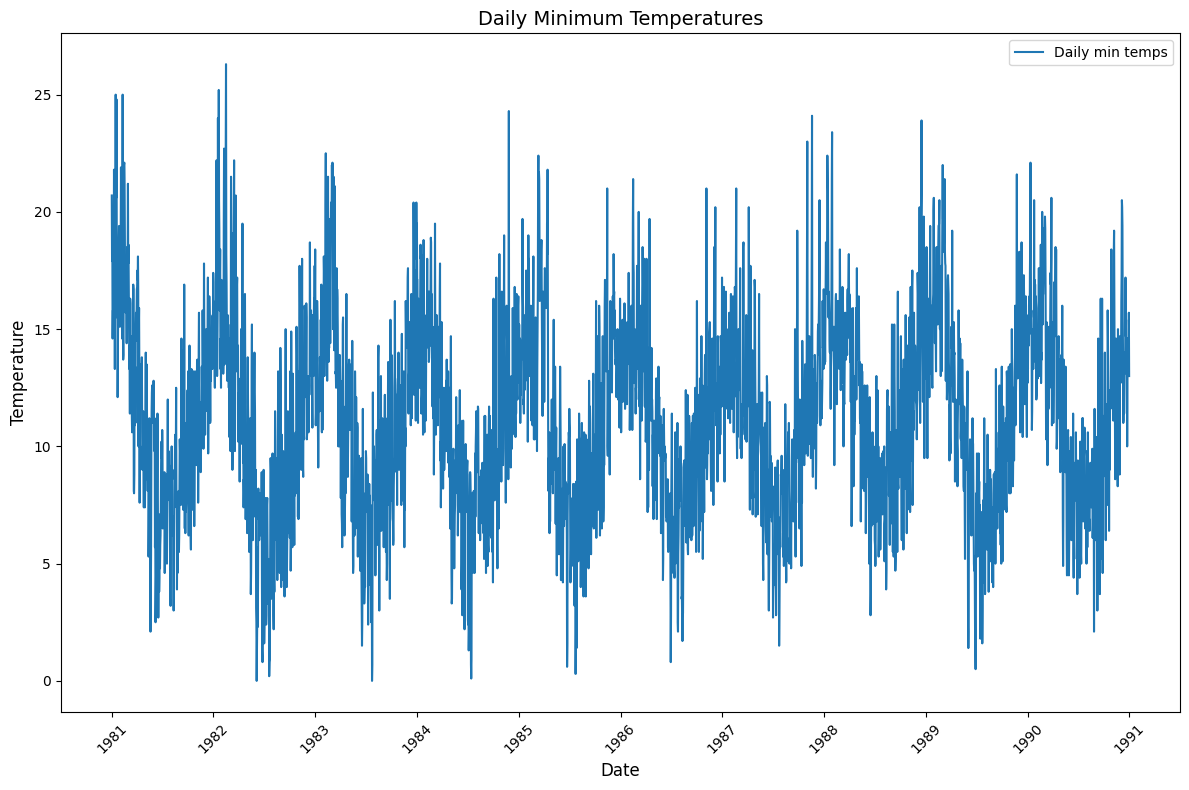

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df['Daily minimum temperatures'], label='Daily min temps')
plt.title('Daily Minimum Temperatures', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [13]:
df = df.rename(columns={
    'Date': 'ds',
    'Daily minimum temperatures': 'y'
})
df['unique_id'] = 'temp_series'


In [14]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [15]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,temp_series,1991-01-01,13.0,11.177753,13.9,12.9
1,temp_series,1991-01-02,13.0,11.177753,13.9,14.6
2,temp_series,1991-01-03,13.0,11.177753,13.9,14.0
3,temp_series,1991-01-04,13.0,11.177753,13.9,13.6
4,temp_series,1991-01-05,13.0,11.177753,13.9,13.5


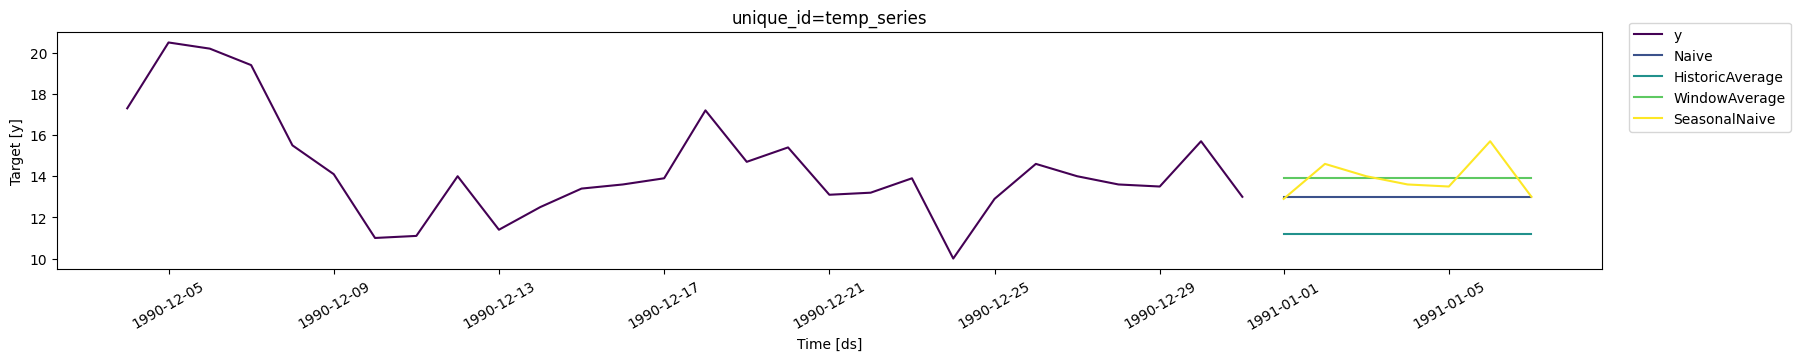

In [16]:
plot_series(
    df=df,
    forecasts_df=preds, 
    max_insample_length=28,
    palette='viridis')

In [17]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [18]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [19]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,temp_series,mae,3.9,2.727477,0.746939,1.628571


In [20]:
evaluation = evaluation.drop(["unique_id"], axis = 1).groupby("metric").mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,3.9,2.727477,0.746939,1.628571


In [21]:
from statsforecast.models import AutoARIMA

In [22]:
unique_id = 'temp_series'
small_train = train[train['unique_id'] == unique_id]
small_test = test[test['unique_id'] == unique_id]

models = [
    AutoARIMA(seasonal=False, alias = "ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds','unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,temp_series,mae,2.284992,2.10385,3.9,2.727477,0.746939,1.628571


In [23]:
arima_eval = arima_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()
arima_eval 

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,2.284992,2.10385,3.9,2.727477,0.746939,1.628571


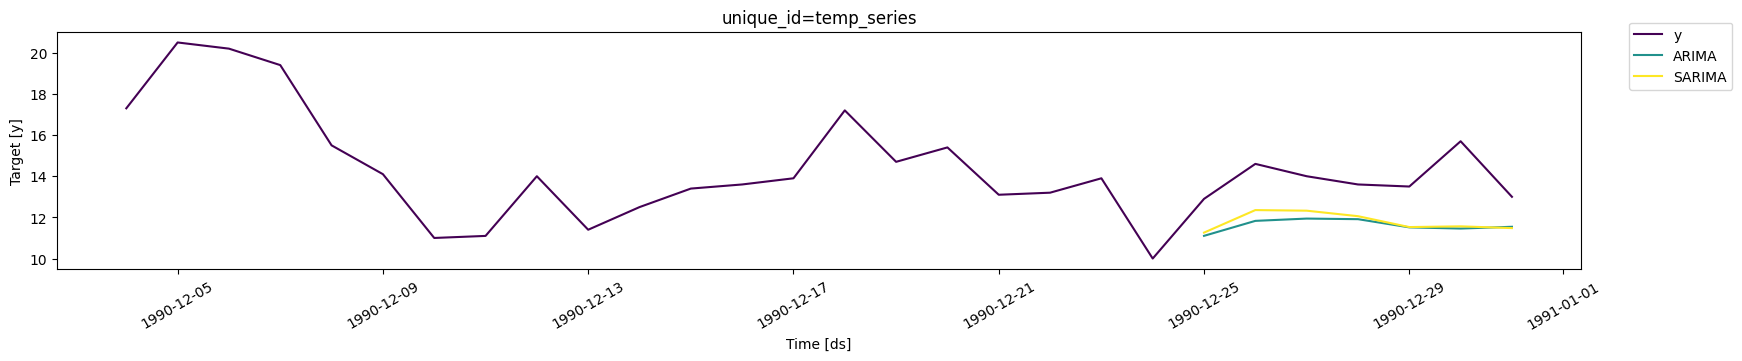

In [24]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    max_insample_length=28,
    palette='viridis'
)

Cross Validation

In [25]:
small_df = df

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,temp_series,1990-11-06,1990-11-05,18.3,14.9,12.798342,13.048451
1,temp_series,1990-11-07,1990-11-05,19.2,14.8,12.347443,12.453626
2,temp_series,1990-11-08,1990-11-05,15.4,15.4,12.191058,12.319272
3,temp_series,1990-11-09,1990-11-05,13.1,11.8,11.990521,11.966940
4,temp_series,1990-11-10,1990-11-05,11.5,13.0,12.031094,11.730668


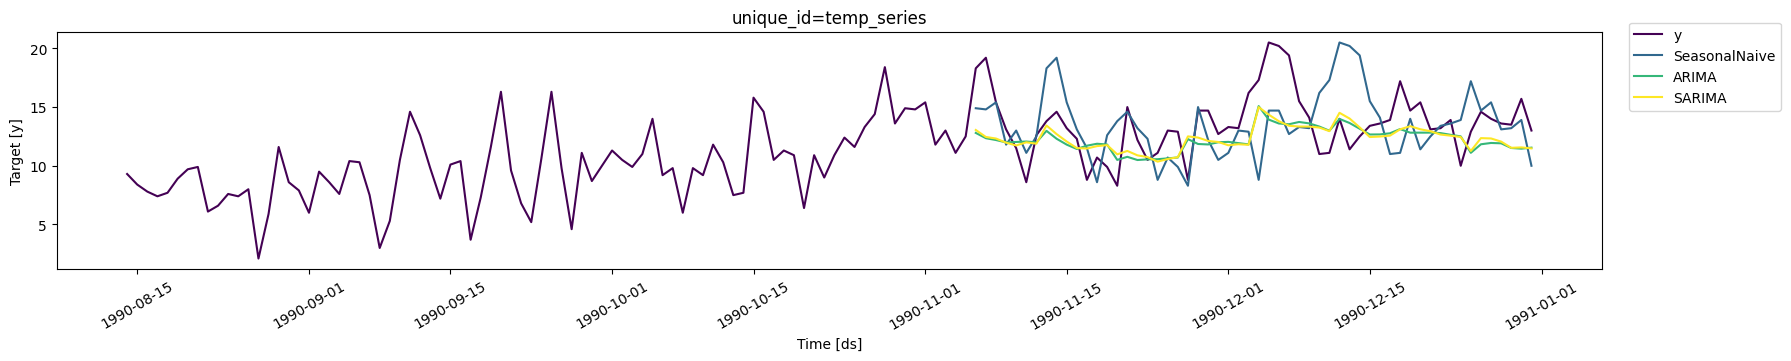

In [26]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(['y','cutoff'],axis=1),
    max_insample_length=140,
    palette="viridis"
)

In [27]:
cv_eval = evaluate(
    cv_df.drop(['cutoff'], axis =1),
    metrics=[mae,
    mae,
    mse,
    rmse,
    mape,
    smape],
)

cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,2.789286,2.235611,2.183218
1,mape,0.209902,0.160493,0.157526
2,mse,12.917857,7.764852,7.333071
3,rmse,3.594142,2.786548,2.707964
4,smape,0.101092,0.084093,0.081926


Forecasting with exogenous features

In [28]:
df2 = pd.read_csv("timeforecast/daily_sales_french_bakery.csv", parse_dates=["ds"])
df2 = df2.groupby('unique_id').filter(lambda x: len(x) >= 28)
df2.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


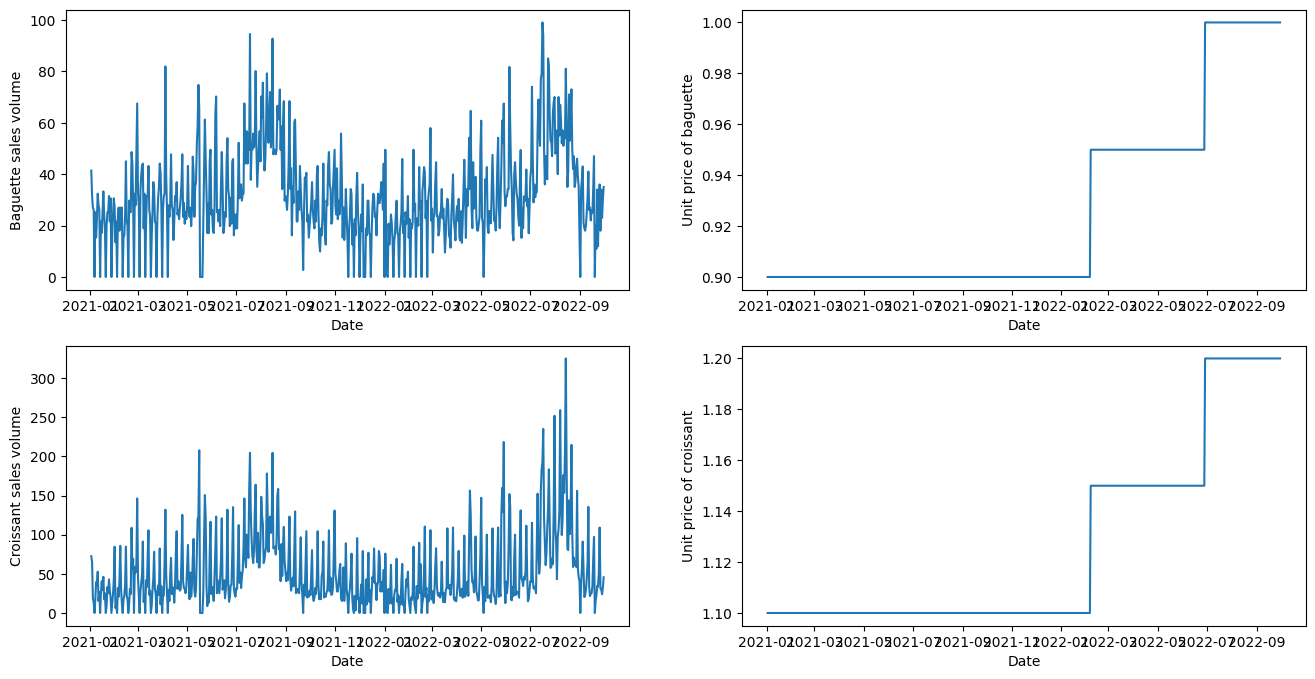

In [29]:
baguette_plot_df = df2[df2['unique_id']=='BAGUETTE']
croissant_plot_df = df2[df2['unique_id']=='CROISSANT']

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df['ds'], baguette_plot_df['y'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df['ds'], baguette_plot_df['unit_price'])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df['ds'], croissant_plot_df['y'])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df['ds'], croissant_plot_df['unit_price'])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate
plt.show()

In [30]:
unique_ids = ['BAGUETTE', 'CROISSANT']
small_df = df2[df2['unique_id'].isin(unique_ids)]
test = small_df.groupby('unique_id').tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [31]:
future_exog_df = test.drop(['y'], axis =1)
future_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [32]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [33]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models = models, freq = "D")
sf.fit(df=train)
arima_exog_preds = sf.predict(h=horizon, X_df=future_exog_df)

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models = models, freq = "D")
sf.fit(df=train.drop(['unit_price'], axis=1))
arima_preds = sf.predict(h=horizon)

In [34]:
test_df = test.merge(arima_exog_preds, on=['unique_id', 'ds'], how='left').merge(arima_preds, on=['unique_id', 'ds'], how='left')
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925
5,BAGUETTE,2022-09-29,30.0,1.0,21.656726,21.288019
6,BAGUETTE,2022-09-30,35.0,1.0,23.101235,22.660124
7,CROISSANT,2022-09-24,51.6,1.2,64.427509,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.128194,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.530880,42.735407


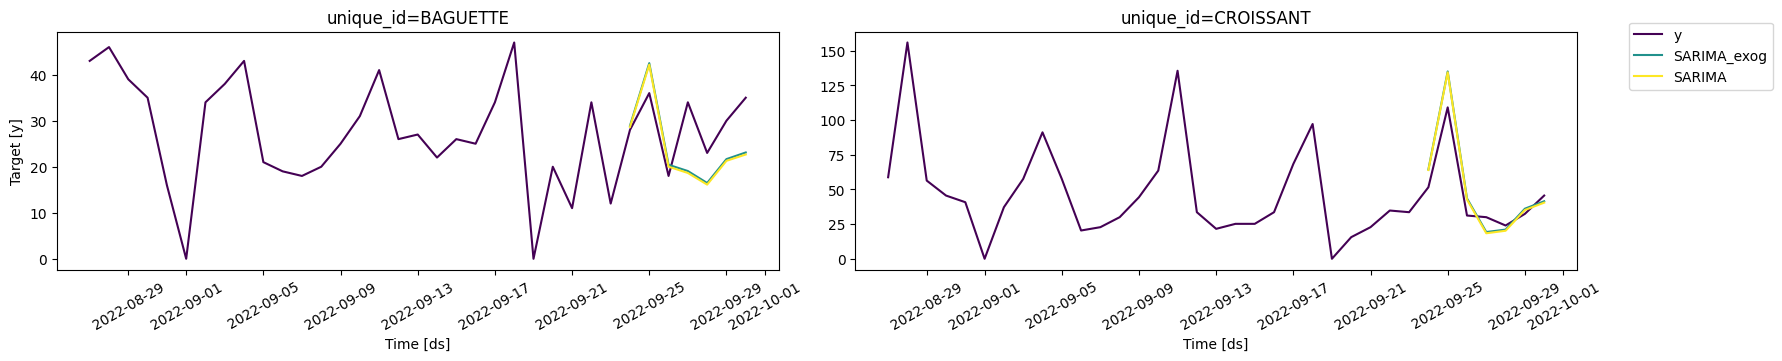

In [35]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=['BAGUETTE', 'CROISSANT'],
    max_insample_length=28,
    models=['SARIMA_exog', 'SARIMA'],
    palette='viridis'
)

In [36]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models = models, freq = "D")

cv_exog_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [37]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(['cutoff'], axis = 1),
    metrics=[mae],
)

cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()

cv_exog_eval

,metric,SARIMA_exog
0,mae,19.210264


Creating features from timestamps

In [38]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [39]:
features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=['day', 'week', 'month'])
]

small_exog_df, futr_exog_df = pipeline(
    df = small_df,
    features=features,
    freq="D",
    h=horizon
)

In [40]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [41]:
futr_exog_df.head()

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10


In [42]:
models = [
    AutoARIMA(season_length=7, alias = "SARIMA_time_exog")
]

sf = StatsForecast(models = models, freq = "D")

cv_time_exog_df = sf.cross_validation(
    h=horizon,
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(['cutoff'], axis = 1),
    metrics=[mae],
)

cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.532809


Prediction Interval

In [43]:
unique_ids = ['BAGUETTE', '12 MACARON']
small_df = df2[df2['unique_id'].isin(unique_ids)]
test = small_df.groupby('unique_id').tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [44]:
train.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [45]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models = models, freq = "D")

sf.fit(df=train)

prob_preds = sf.predict(h=horizon, X_df=test.drop(['y'], axis =1), level = [80])

In [46]:
test_df = test.merge(prob_preds, on=['unique_id','ds'], how='left')

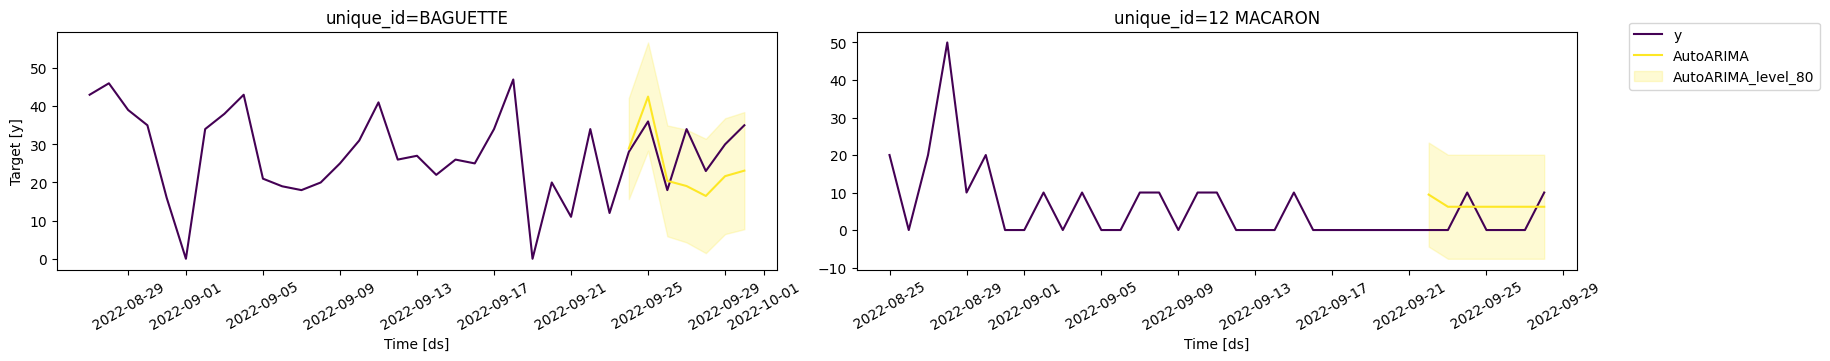

In [47]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=['BAGUETTE', '12 MACARON'],
    max_insample_length=28,
    models=['AutoARIMA'],
    level=[80],
    palette='viridis'
)

In [48]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq = "D")

cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80]
)

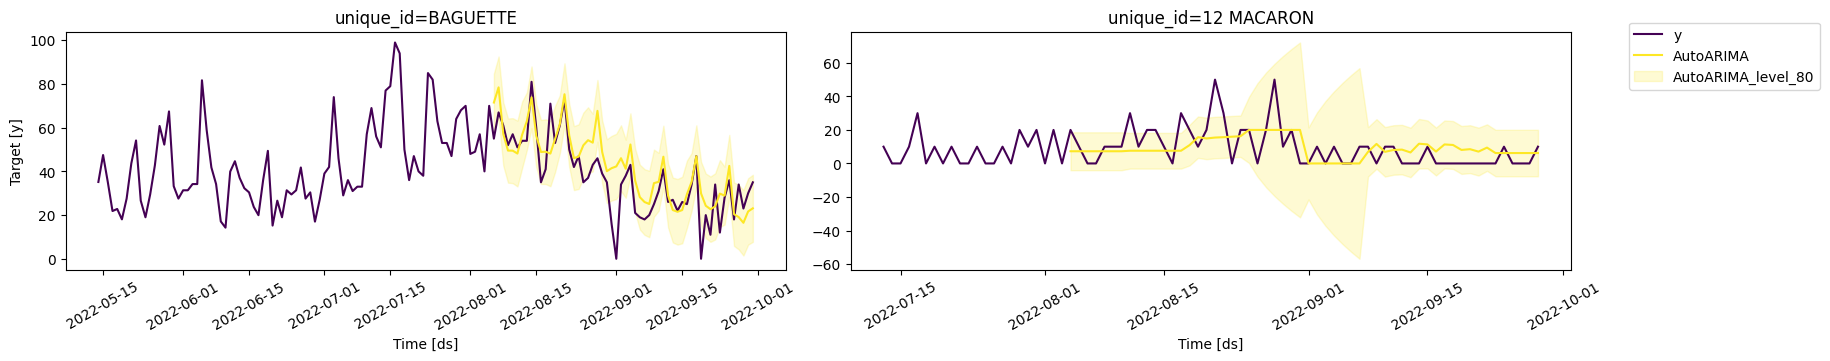

In [49]:
plot_series(
    df=small_df,
    forecasts_df=cv_prob_df.drop(['y','cutoff'], axis = 1),
    ids=['BAGUETTE', '12 MACARON'],
    models=['AutoARIMA'],
    max_insample_length=140,
    level=[80],
    palette='viridis'
)

Evaluation Metrics

In [50]:
models = [
    AutoARIMA(season_length=7, alias = "SARIMA_exog"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")

final_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80]
)

In [51]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,12 MACARON,2022-08-04,2022-08-03,20.0,7.272727,-4.039975,18.585429,0.0,-15.163523,15.163523
1,12 MACARON,2022-08-05,2022-08-03,10.0,7.272727,-4.039975,18.585429,20.0,4.836477,35.163523
2,12 MACARON,2022-08-06,2022-08-03,0.0,7.272727,-4.039975,18.585429,10.0,-5.163523,25.163523
3,12 MACARON,2022-08-07,2022-08-03,0.0,7.272727,-4.039975,18.585429,20.0,4.836477,35.163523
4,12 MACARON,2022-08-08,2022-08-03,10.0,7.272727,-4.039975,18.585429,0.0,-15.163523,15.163523


In [52]:
temp_test = small_df.groupby('unique_id').tail(7*8)
temp_train = small_df.drop(test.index).reset_index(drop=True)

In [53]:
models = ['SARIMA_exog', 'SeasonalNaive']
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality = 7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(['ds', 'cutoff'], axis=1),
    metrics=metrics,
    models=models,
    train_df=temp_train, #passing this because of the mase metric
    level=[80]
)

final_eval = final_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,8.586538,10.250000
1,mape,0.359377,0.549503
2,mase,0.846366,1.010370
3,mse,132.190580,182.392857
4,rmse,11.486518,13.497028
5,scaled_crps,0.312818,0.315102
6,smape,0.347898,0.366742
